## DSO signal analysis

In [21]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


Assign the filename and read the data in:

In [22]:
filename='TOR3_20.CSV'
data=np.loadtxt(filename,delimiter=',',skiprows=15)

Define frequency:

In [23]:
f=100000

Read timebase from file:

In [24]:
import re
text = open(filename).read()
line9=re.search('Horizontal Scale,(\d\.\d+)',text)
hScale=line9.groups()[0]
timebase=float(hScale)*1e-3

Create time, $V_{L}$ and $V_{R}$ ($V_{L}$ is the difference between the first and second columns):

In [25]:
points=data[:,0]
time=(points-1)*timebase*1000/50
Vl=data[:,1]-data[:,2]
Vr=data[:,2]

Experimental data:

Text(0, 0.5, 'Voltage')

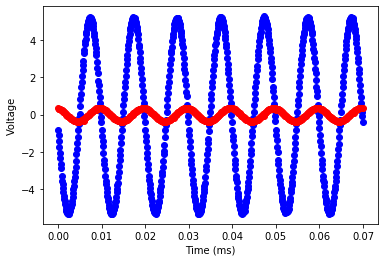

In [26]:
plt.plot(time, Vl,'bo',time,Vr,'ro');
plt.xlabel('Time (ms)')
plt.ylabel('Voltage')

### Data fitting:

Fitting data to:

V = $C + A \sin(2 \pi f t +\phi )$

Define function to fit.

In [27]:
def voltage(ft,c,A,phi):
    return c+A*np.sin(2*np.pi*ft/1e3+phi)

Define fitting function:

In [28]:
def fitVoltage(voltage,Vdata,f,time):
    Aguess=Vdata.max()
    from scipy.optimize import curve_fit
    fitpars1, cov=curve_fit(voltage,f*time,Vdata,p0=[0,Aguess,0]) #p0 is the starting guess [offset, A, phi]
    if fitpars1[1]<0:
        C=fitpars1[0]
        A=-fitpars1[1]
        if fitpars1[2]<0:
            phi=fitpars1[2]+np.pi
        else:
            phi=fitpars1[2]-np.pi    
    else:
        C=fitpars1[0]
        A=fitpars1[1]
        phi=fitpars1[2]
    
    #print('Offset = '+ str(C) + '\nAmplitude = '+str(A)+'\nPhase = '+str(phi))
    return [C,A,phi]

Fit for $V_{L}$:

In [29]:
VlOffset,VlAmplitude,VlPhase=fitVoltage(voltage,Vl,f,time)
print('VlOffset = '+ str(VlOffset) + '\nVlAmplitude = '+str(VlAmplitude)+'\nVlPhase = '+str(VlPhase))

VlOffset = -0.11059999568102968
VlAmplitude = 5.291273041256614
VlPhase = -3.027527296312056


Fit for $V_{R}$:

In [30]:
VrOffset,VrAmplitude,VrPhase=fitVoltage(voltage,Vr,f,time)
print('VrOffset = '+ str(VrOffset) + '\nVrAmplitude = '+str(VrAmplitude)+'\nVrPhase = '+str(VrPhase))

VrOffset = -0.01671428569902645
VrAmplitude = 0.36527886491908906
VrPhase = 1.8860803458716406


### Plotting the fits:

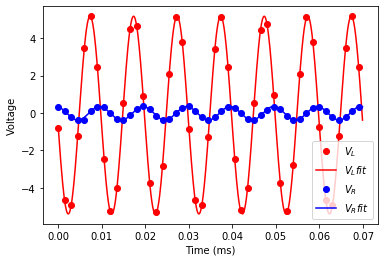

In [31]:
VlFit=voltage(f*time,VlOffset,VlAmplitude,VlPhase)
VrFit=voltage(f*time,VrOffset,VrAmplitude,VrPhase)
# only plotting every 15 points so the fit can be seen more clearly
plt.plot(time[::15], Vl[::15],'or',time, VlFit ,'r-')
plt.plot(time[::15], Vr[::15],'ob',time, VrFit ,'b-')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage')
plt.legend(('$V_{L}$','$V_{L} fit$','$V_{R}$','$V_{R} fit$'), loc=0);

## Calculating impedance (z), inductance (L) and tan $\delta$
Now we use the values from the fit to calulate the impedance, inductance and tan delta. These are given by:

$z=V_{L}/I_{L}$ where $I_{L}=\frac{V_{r}}{R}$ , where R is the resistance of the sense resistor in $\Omega$ 

$L=\frac{z}{2\pi f}$ 

and 

$\tan \delta=\tan (\phi_{c}-\phi_{r} + \frac{\pi}{2})$

In [32]:
def impedance(Vl,Vr,R):
    I=Vr/R
    z=Vl/I
    print('Current=' + str(I)+'A')
    return z

In [33]:
def inductance(f,z):
    L=z/(2*np.pi*f)
    return L

In [34]:
def phase_angle_deg(phil,phiR):
    phi_deg=(phil-phiR)*180/np.pi
    return phi_deg

In [35]:
def tanDelta(phil,phiR):
    tanD=np.tan(phil-phiR+np.pi/2)
    return tanD

Now we can calculate them:

In [36]:
R=50 #sense resitor 50 Ohm
Z=impedance(VlAmplitude,VrAmplitude,R)
L=inductance(f,Z)
phi_deg=phase_angle_deg(VlPhase,VrPhase)
tanD=tanDelta(VlPhase,VrPhase)
print('Impedance= '+ str(Z) +' Ohm'+
      '\nphi = ' +str(phi_deg) + ' °'+
      '\nInductance = ' + str(L) + ' H'+
      '\ntan delta= '+str(tanD))

Current=0.007305577298381782A
Impedance= 724.2785648751748 Ohm
phi = -281.5289800803534 °
Inductance = 0.0011527251377538808 H
tan delta= -0.20397908790511501


In [37]:
R=10 #sense resitor 10 Ohm
Z=impedance(VlAmplitude,VrAmplitude,R)
L=inductance(f,Z)
phi_deg=phase_angle_deg(VlPhase,VrPhase)
tanD=tanDelta(VlPhase,VrPhase)
print('Impedance= '+ str(Z) +' Ohm'+
      '\nphi = ' +str(phi_deg) + ' °'+
      '\nInductance = ' + str(L) + ' H'+
      '\ntan delta= '+str(tanD))

Current=0.036527886491908905A
Impedance= 144.85571297503498 Ohm
phi = -281.5289800803534 °
Inductance = 0.0002305450275507762 H
tan delta= -0.20397908790511501
